In [1]:
import torch
import numpy as np
import os
import sys

src_path = os.path.abspath(os.path.join("src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print(sys.path)

['/nethome/abhalerao9/TIMESERIESMODELING/TSFMProject/src', '/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python311.zip', '/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11', '/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11/lib-dynload', '', '/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11/site-packages']


In [2]:
from tsfmproject.model import ChronosModel
from tsfmproject.dataset import ChronosDataset
from tsfmproject.visualization import ForecastVisualization

/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM.


In [ ]:
# Get the base path from sys.path[0]
base_path = sys.path[0]

# # Relative file location
# relative_file_location = '../data/dataset/ETTh1.csv'

# # Combine the base path with the relative file location
# file_location = os.path.join(base_path, relative_file_location)


Chdataset = ChronosDataset(name="ett", path='/nethome/sli999/TSFMProject/src/tsfmproject/models/moment/data/ETTh1.csv', datetime_col='date', freq='H')

data = Chdataset.dataset
data_loc = os.path.join(sys.path[0],'./tsfmproject/models/chronosforecasting/data/us_data.arrow')
offset = -60
# slice data in the last offset rows
data_train = data.iloc[:offset]
data_test = data.iloc[offset:]
start_date = str(data_train.index[0])
# make a list of the columns except 'ds' columns and make a list of all the time series in those columns
column_list = data_train.columns.tolist()
time_series_list = [np.array(data_train[column].values) for column in column_list]

In [4]:
print(time_series_list)

[array([ 5.82700014,  5.69299984,  5.15700006, ..., 15.73999977,
       13.73099995,  9.04199982]), array([2.00900006, 2.07599998, 1.74100006, ..., 5.76000023, 4.95699978,
       5.42500019]), array([ 1.59899998,  1.49199998,  1.27900004, ..., 10.16300011,
        8.24400043,  3.30500007]), array([0.46200001, 0.426     , 0.35499999, ..., 2.91400003, 2.0250001 ,
       3.05599999]), array([4.20300007, 4.1420002 , 3.77699995, ..., 5.39099979, 5.4829998 ,
       5.39099979]), array([1.34000003, 1.37100005, 1.21800005, ..., 1.67499995, 1.73599994,
       1.76699996]), array([30.53100014, 27.78700066, 27.78700066, ...,  6.89400005,
        7.45699978,  7.45699978])]


In [5]:
Chdataset.convert_to_arrow(data_loc, time_series=time_series_list, start_date=start_date)

In [6]:
repo = "amazon/chronos-t5-small"
ch = ChronosModel(config=None, repo=repo)

In [10]:
ch.finetune(training_data_paths=[data_loc], probability_list=[1])

The speedups for torchdynamo mostly come wih GPU Ampere or higher and which is not detected here.
max_steps is given, it will override any value given in num_train_epochs
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
5,3.963000
10,3.906900
15,3.885500
20,3.891400
25,3.880900
30,3.849000
35,3.825700
40,3.834500
45,3.841000
50,3.826700


/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/nethome/abhalerao9/anaconda3/envs/timesfm/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [7]:
results = {}
latest_run_dir = ch.get_latest_run_dir()
model_dir = os.path.join(latest_run_dir, "checkpoint-final")
model_type = "seq2seq"
metrics = ['RMSE', 'MAPE']
model = ch.load_model(model_dir, model_type)
ch.result_logger.info(f"Model loaded from {model_dir}")

In [8]:
eval_results, trues, preds, histories = ch.evaluate(data_train, data_test, metrics)


In [9]:
print(preds.shape)


(7, 60)


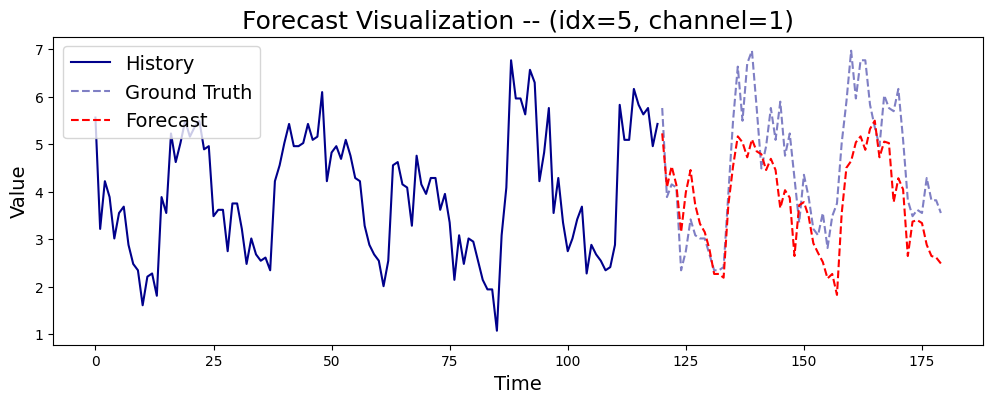

In [14]:
visualization = ForecastVisualization(trues, preds, histories[:,-2*len(preds[0]):])
visualization.plot()

(120,) (60,) (60,)


NameError: name 'time_index' is not defined

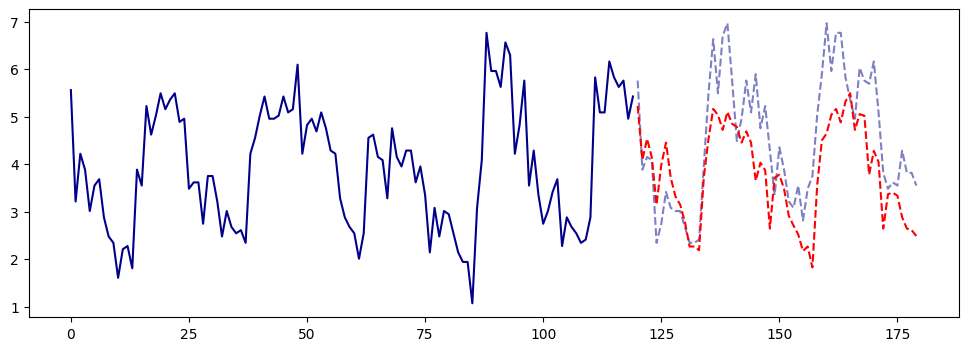

In [13]:
import matplotlib.pyplot as plt

channel_idx = 1
history = histories[channel_idx, -2*len(preds[0]):]
true = trues[channel_idx, :]
pred = preds[channel_idx, :]
print(history.shape, true.shape, pred.shape)

plt.figure(figsize=(12, 4))
plt.plot(range(len(history)), history, label='History', c='darkblue')
offset = len(history)
plt.plot(range(offset, offset + len(true)), true, label='Ground Truth', color='darkblue', linestyle='--', alpha=0.5)
plt.plot(range(offset, offset + len(pred)), pred, label='Forecast', color='red', linestyle='--')
plt.title(f"Forecast Visualization -- (idx={time_index}, channel={channel_idx})", fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=14)
plt.show()